# Мобильное приложение по продаже продуктов питания 

## Общее описание проекта

Имеется мобильное приложение по продаже продуктов питания. С целью улучшения взаимодействия пользователей с приложением дизайнеры поменяли шрифты. Однако для принятия окончательного решения о переходе на приложение с новыми шрифтами проведен `A/B`-тест: 
- группа пользователей `A` работа со старой версией приложения;
- группа пользователей `B` работа с новой версией приложения.


В Вашем распоряжении результаты проведенного `A/B`-теста. Необходимо выяснить повлияло ли изменение шрифтов на поведение пользователей.

## Описание данных 

Имеется лог-файл, содержащий информацию о действиях пользователя нашего мобильного приложения. Каждая запись в логе — это действие пользователя, или событие.

|Признак|Описание|
|----:|:----|
|EventName | название события|
|DeviceIDHash | уникальный идентификатор пользователя|
|EventTimestamp | время события|
|ExpId | номер эксперимента: 247 контрольная группа, а 248 — экспериментальная|

## Инструкция по выполнению проекта
- Шаг 1. Открыть файл с данными и изучить общую информацию
- Шаг 2. Подготовить данные
    - Заменить названия столбцов на удобные для вас;
    - Проверить пропуски и типы данных. Откорректировать, если нужно;
    - Добавить столбец даты и времени, а также отдельный столбец дат;
- Шаг 3. Изучить и проверить данные
    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?
    - Данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что данные одинаково полные за весь период? Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
    - Много ли событий и пользователей потеряли, отбросив старые данные?
    - Проверить, что у нас есть пользователи из всех групп.
- Шаг 4. Изучить воронку событий
    - Посмотреть, какие события есть в логах, как часто они встречаются. Отсортировать события по частоте.
    - Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие.
    - Предположить, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
    - По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
    - На каком шаге теряете больше всего пользователей?
    - Какая доля пользователей доходит от первого события до оплаты?
- Шаг 5. Изучить результаты эксперимента
    - Сколько пользователей в каждой группе?
    - Выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой группе. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий?
    - Сделать выводы из эксперимента.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных

In [5]:
df = pd.read_csv('ab_test.csv', 
                 delimiter = '\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,1564054127,248
1,CartScreenAppear,3518123091307005509,1564054127,248
2,PaymentScreenSuccessful,6217807653094995999,1564055322,248
3,CartScreenAppear,6217807653094995999,1564055323,248
4,MainScreenAppear,1850981295691852772,1564086702,247


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  int64 
 3   ExpId           163822 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.0+ MB


In [6]:
df.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,1.638220e+05,1.638220e+05,163822.000000
mean,4.667422e+18,1.564911e+09,247.523416
std,2.582490e+18,1.773846e+05,0.499453
min,6.909562e+15,1.564054e+09,247.000000
25%,2.458858e+18,1.564754e+09,247.000000
50%,4.623192e+18,1.564917e+09,248.000000
75%,6.887424e+18,1.565072e+09,248.000000
max,9.222603e+18,1.565212e+09,248.000000


In [15]:
df.loc[df.duplicated()].shape[0]

290

In [6]:
# можно так посчитать
df.duplicated().sum()

290

In [9]:
var_desc = ['EventName', 'ExpId']

for col in var_desc:
    print('----{}----'.format(col))
    print(df[col].unique()) 
    print('--------')
    

----EventName----
['PaymentScreenSuccessful' 'CartScreenAppear' 'MainScreenAppear'
 'Tutorial' 'OffersScreenAppear']
--------
----ExpId----
[248 247]
--------


# Предобработка данных

1. Корректировка заголовков; 
2. Преобразование типов;
3. Удаление дублей.


## Корректировка заголовков

In [7]:
df.columns = ['event_name', 'user_id', 'event_date_time', 'exp_id']

In [ ]:
# df.rename({'':'',
           
#            axis = 1})

In [8]:
df.columns

Index(['event_name', 'user_id', 'event_date_time', 'exp_id'], dtype='object')

In [9]:
df['event_date_time'] = pd.to_datetime(df['event_date_time'], origin='unix', unit = 's')

In [12]:
df.head()

,event_name,user_id,event_date_time,exp_id
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163822 non-null  object        
 1   user_id          163822 non-null  int64         
 2   event_date_time  163822 non-null  datetime64[ns]
 3   exp_id           163822 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.0+ MB


In [13]:
df['event_date'] = df.event_date_time.dt.date

In [15]:
df.head()

,event_name,user_id,event_date_time,exp_id,event_date
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
2,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
3,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
4,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25


In [16]:
#df_new = df.loc[~df.duplicated()]

df.drop_duplicates(inplace = True)

In [17]:
df.duplicated().sum()

0

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163532 non-null  object        
 1   user_id          163532 non-null  int64         
 2   event_date_time  163532 non-null  datetime64[ns]
 3   exp_id           163532 non-null  int64         
 4   event_date       163532 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 7.5+ MB


# Изучить и проверить данные

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что данные одинаково полные за весь период? Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
- Много ли событий и пользователей потеряли, отбросив старые данные?
- Проверить, что у нас есть пользователи из всех групп.


In [21]:
print('''
Всего событий --- {}.
Уникальных событий --- {}.
'''.format(df.shape[0], len(df.event_name.unique())))


Всего событий --- 163532. 
Уникальных событий --- 5.



In [22]:
print('Всего пользователей --- {}.'.format(df.user_id.nunique()))

Всего пользователей --- 5062.


In [23]:
len(df.user_id.unique())

5062

In [24]:
#Сколько в среднем событий приходится на пользователя?
int(df.groupby('user_id').event_name.count().mean())

32

In [25]:
int(df.groupby('user_id').event_name.count().median())

20

In [28]:
int(df.groupby('user_id').event_name.count().mode()[0])

5

In [ ]:
# Данными за какой период мы располагаем? 
# Найти максимальную и минимальную дату. 
# Построить гистограмму по дате и времени. 
# Можно ли быть уверенным, что данные одинаково полные за весь период? 
# Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?

In [29]:
df.event_date.min()

datetime.date(2019, 7, 25)

In [30]:
df.event_date.max()

datetime.date(2019, 8, 7)

In [31]:
df.event_date.max() - df.event_date.min()

datetime.timedelta(days=13)

In [33]:
df.event_date.unique()

array([datetime.date(2019, 7, 25), datetime.date(2019, 7, 26),
       datetime.date(2019, 7, 27), datetime.date(2019, 7, 28),
       datetime.date(2019, 7, 29), datetime.date(2019, 7, 30),
       datetime.date(2019, 7, 31), datetime.date(2019, 8, 1),
       datetime.date(2019, 8, 2), datetime.date(2019, 8, 3),
       datetime.date(2019, 8, 4), datetime.date(2019, 8, 5),
       datetime.date(2019, 8, 6), datetime.date(2019, 8, 7)], dtype=object)

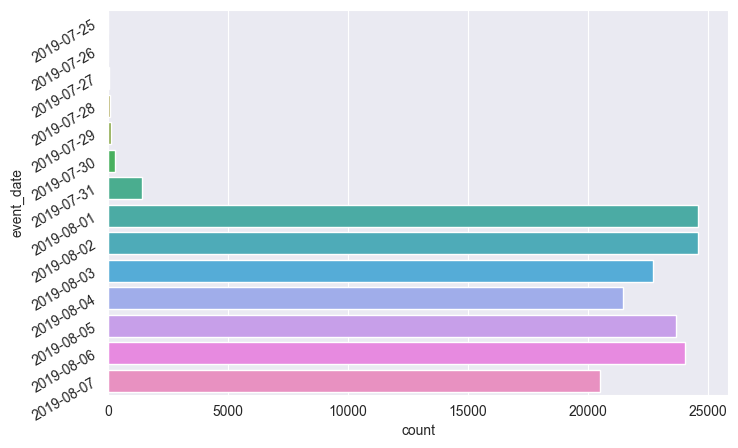

In [39]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
ax = sns.countplot(y = 'event_date', data = df)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, fontsize = 10);
#ax.set({''})
